# Algorytm genetyczny

## Cel doświadczenia

Zbadanie modelu podanego w opisie ćwiczenia za pomcą algorytmu genetycznego z selekcją ruletkową, kryżowaniem jednopunktowym i sukcesją generacyjną.
Porównanie wpływu wybranego hiperparametru na wynik doświadczenia.

Wybrany hiperparametr **prawdopodobieństwo mutacji**

## Funkcja celu

Ewaluuje ona zysk osobników w danej populacji.

In [41]:
import math

def evaluation(population: list):
    speed = 0
    acceleration = -0.09
    score_list = []
    for individual in population:
        individual_score = 0
        mass = 200
        distance = 200

        fuel = 0
        for x in individual:
            fuel += 1 if x == 1 else 0

        mass += fuel
        for value in individual:
            if value == 1:
                acceleration = -0.09 + 45/mass
                mass -= 1
            else:
                acceleration = -0.09

            # time = 1 so we do not need to write it
            distance += speed
            speed +=  acceleration

            if distance < 2 and math.fabs(speed) < 2:
                individual_score = 2000 - fuel
                break
        else:
            individual_score = -1000 - fuel
        
        score_list.append(individual_score)

    return score_list

## Interfejs algorytmu

In [42]:
from abc import ABC, abstractmethod
import random
import math

class Solver(ABC):
    """A solver. It may be initialized with some hyperparameters."""

    @abstractmethod
    def get_parameters(self):
        """Returns a dictionary of hyperparameters"""
        pass

    @abstractmethod
    def solve(self, problem, pop0, *args, **kwargs):
        """
        A method that solves the given problem for given initial solutions.
        It may accept or require additional parameters.
        Returns the solution and may return additional info.
        """
        pass

## Algorytm


#### Funkcja solve

Aktywuje algorytm dla zadanych parametrów. Należy podać jej funckję celu i populację, można podać jej też hiperparametry poprzez mechanizm **kwargs.

**W przypadku nie podania hiperparametrów algorytm wystartuje z ich domyślnymi wartościami.**

Hiperparametry:
* quantity_of_population 
* mutation_possibility  (domyślnie 0.01)
* crossing_possibility  (domyślnie 0.6)
* max_iteration (domyślnie 25)


#### Funkcja get_parameters

Zwraca domyślnie hiperparametry w postaci słownika.

In [43]:
import random

class GeneticAlgorithm(Solver):

    def __init__(self) -> None:
        self.quantity_of_population = 200
        
        self.mutation_possibility = 0.01
        self.crosing_possibility = 0.7
        self.max_iteration = 25
        self.hyperparameters = {
            'quantity_of_population': self.quantity_of_population,
            "mutation_possibility": self.mutation_possibility,
            'crossing_possibility': self.crosing_possibility,
            'max_iteration': self.max_iteration
        }
  


    def get_parameters(self):
        'Return default parmetrs in a dictionary'
        return self.hyperparameters
    
    
    
    def _find_the_best(self, population, score_list):
        'Choose an individual with the highest score'
        best_score = max(score_list)
        best_index = score_list.index(best_score)
        best_individual = population[best_index]
        return best_individual, best_score

    
    def _scaling(self, weights: list):
        if max(weights) != min(weights):
            return [(x - min(weights)/(max(weights) - min(weights))) for x in weights ]
        else:
            return [1 for x in weights]
            


    def _reproduction(self, population, score_list):
        'Roulette selection'
        size = len(population)

        # Making all weights positive
        weights = [score + 1300 for score in score_list]

        weights = self._scaling(weights)
        suma = sum(weights)
        pass
        next_generation = random.choices(population, weights=weights, k=size)
        
        return next_generation

    
    def _corssing_individuals(self, individual1, individual2):
        'Cross two individuals'
        length = len(individual1)

        crossing_point = random.randint(0, length)

        for index in range(0, crossing_point):
            individual2[index] = individual1[index]
        
        for index in range(crossing_point, length):
            individual1[index] = individual2[index]

        return individual1, individual2
    

    def _choosing_if_we_exchange(self, possibility):
        'Draw betwen two possibilities taking in consideration probabilities of those elements'
        possibilities = [True, False]
        possibility_not = 1 - possibility
        weights = [possibility, possibility_not]
        decision = random.choices(possibilities, weights, k=1)

        return decision[0]

    
    def _crossing(self, population, probability):
        'Crossing individual in the given population'
        # assuming that the population is even
        crossings_quantity = int(len(population)/2)
        population_quantity = len(population)
        indexes_to_cross = [x for x in range(population_quantity)]
        for i in range(crossings_quantity):
            rand_index1 = None
            rand_index2 = None
            while rand_index1 is None:
                rand_index1 = random.choice(indexes_to_cross)
            index_to_remove = indexes_to_cross.index(rand_index1)
            indexes_to_cross[index_to_remove] = None
            individual1 = population[rand_index1]

            while rand_index2 is None:
                rand_index2 = random.choice(indexes_to_cross)
            index_to_remove = indexes_to_cross.index(rand_index2)
            indexes_to_cross[index_to_remove] = None
            individual2 = population[rand_index2]
            
            if self._choosing_if_we_exchange(probability):
                individual1, individual2 = self._corssing_individuals(individual1, individual2)

                population[rand_index1] = individual1
                population[rand_index2] = individual2

        return population

    
    def _mutation(self, population, probability):
        'Mutates genes in the given population'
        for individual in population:
            length = len(individual)
            for index in range(length):
                if self._choosing_if_we_exchange(probability):
                    individual[index] = 0 if individual[index] == 1 else 0
                    
        return population

    def _update_parameters(self, kwargs):
        self.quantity_of_population = self.quantity_of_population if "quantity_of_population" not in kwargs else kwargs["quantity_of_population"]
        self.mutation_possibility = self.mutation_possibility if "mutation_possibility" not in kwargs else kwargs["mutation_possibility"]
        self.crossing_possibility = self.crosing_possibility if "crossing_possibility" not in kwargs else kwargs["crossing_possibility"]
        self.max_iteration = self.max_iteration if "max_iteration" not in kwargs else kwargs["max_iteration"]



    def solve(self, problem, pop0, *args, **kwargs):
        'Activates the genetic algorithm'
        # Initialization

        self._update_parameters(kwargs)

        quantity_of_population = self.quantity_of_population
        mutation_possibility = self.mutation_possibility
        crossing_possibility = self.crosing_possibility
        max_iteration = self.max_iteration
        
        
        population = pop0[0:quantity_of_population]

        score_list = problem(population)
        best_individual, best_score = self._find_the_best(population, score_list)

        for i in range(max_iteration):
            population = self._reproduction(population, score_list)
            population = self._crossing(population, crossing_possibility)
            population = self._mutation(population, mutation_possibility)
            score_list = problem(population)
            best_individual_trial, best_score_trial = self._find_the_best(population, score_list)
            if best_score_trial > best_score:
                best_individual = best_individual_trial
                best_score = best_score_trial
        return best_individual, best_score

### Hiperparametry przy których algorytm pracuje optymalnie

* quantity_of_population = 200
* mutation_possibility = 0.01 powinno być bardzo małe, to tylko pomocniczy mechanizm
* crossing_possibility = 0.6 to jest główny motor algorytmu
* max_iteration = 25

## Testowanie algorytmu dla różnych wartości parawdopodobieństwa krzyżowania (pm)

##### Stworzenie obiektu klasy GenericAlgorithm

In [44]:
from copy import deepcopy
gene_algoritm = GeneticAlgorithm()
average_scores = []

In [45]:
populations = []
for i in range(100):
    initial_population = [[random.randint(0, 1) for x in range(200)] 
                           for y in range(200)]
    populations.append(deepcopy(initial_population))

### Dla pm = 0.01

In [46]:
average_score = 0
for i in range(100):
    initial_population = deepcopy(populations[i])
    
    individual, score = gene_algoritm.solve(evaluation, initial_population, crossing_probability=0.01)
    average_score += score
average_score /= 100
average_scores.append(average_score)

### Dla pm = 0.03

In [47]:
average_score = 0
for i in range(100):
    initial_population = deepcopy(populations[i])
    
    individual, score = gene_algoritm.solve(evaluation, initial_population, mutation_possibility=0.03)
    average_score += score
average_score /= 100
average_scores.append(average_score)

### Dla pm = 0.07

In [48]:
average_score = 0
for i in range(100):

    initial_population = deepcopy(populations[i])
    
    individual, score = gene_algoritm.solve(evaluation, initial_population, mutation_possibility=0.07)
    average_score += score
average_score /= 100
average_scores.append(average_score)

### Dla pm = 0.1

In [49]:
average_score = 0
for i in range(100):

    initial_population = deepcopy(populations[i])
    
    individual, score = gene_algoritm.solve(evaluation, initial_population, mutation_possibility=0.1)
    average_score += score
average_score /= 100
average_scores.append(average_score)

### Dla pm = 0.3

In [50]:
average_score = 0
for i in range(100):
    initial_population = deepcopy(populations[i])
    
    individual, score = gene_algoritm.solve(evaluation, initial_population, mutation_possibility=0.3)
    average_score += score
average_score /= 100
average_scores.append(average_score)

### Dla pm = 0.7

In [51]:
average_score = 0
for i in range(100):
    initial_population = deepcopy(populations[i])
    individual, score = gene_algoritm.solve(evaluation, initial_population, mutation_possibility=0.7)
    average_score += score
average_score /= 100
average_scores.append(average_score)

### Wykres zależności

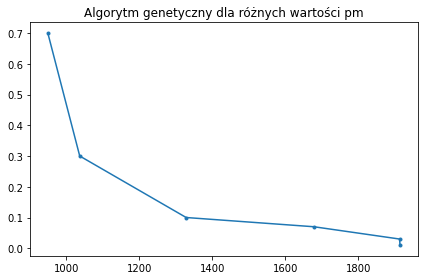

In [53]:
%matplotlib inline

from matplotlib import pyplot as plt

probability_list = [0.01, 0.03, 0.07, 0.1, 0.3, 0.7]


plt.plot(average_scores, probability_list, marker='.')
plt.title('Algorytm genetyczny dla różnych wartości pm')
plt.tight_layout()
plt.show()

## Podsumowanie

Z powyższego wykresu widać, że dla losowo wygenerowanych populacji średnio algortym radzi sobie najlepiej z najmniejszymi wartościami pm (0.01, 0.03). Wynik jest wiążący, pownieważ każda wartość parametru została przetestowana na identycznych populacjach wejściowych.  
Doświadczenie pokazuje, że parametr pm jest tylko mechanizmem pomocniczym w algortymie genetycznym, zwiększającym różnorodność populacji. Jeżeli zwiększy się za bardzo prawdopodobieństwo mutacji _niszczy_ ona silne osobniki w populacji, co widać po śrenich na wykresie.